# Notebook for Bayesian Best-Arm Idenfitication

### Libraries

In [1]:
# Imports and defaults
import itertools
import joblib
from joblib import Parallel, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import block_diag
import scipy.optimize as spo
from scipy import optimize
import time
from collections import defaultdict
import random
from numpy.linalg import pinv
from tqdm.auto import tqdm

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 9
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)
print("%d joblib cores" % joblib.cpu_count())

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

np.random.seed(0)
random.seed(0)

python 3.9.13
matplotlib 3.5.2
8 joblib cores


### Useful Functions

In [2]:
def norm2_matrix(x, A) :
    return x.T @ A @ x

def fac_compute_Sigma_hat_n(n, omega, A, Sigma_0_inv):
    sum_ = A.T.dot(n * omega[:, None] * A)
    return np.linalg.inv(Sigma_0_inv + sum_)

def fac_Cova_hat_mu_n(sigma, omega, Sigma_0, A, Sigma_hat_n, n):
    K, d = A.shape
    
    helper_ = n * omega * (sigma**2 + np.sum(A.dot(Sigma_0) * A, axis=1))
    variance_terms = A.T.dot(helper_[:, None] * A)
    
    helper1 = np.outer(n*omega, n*omega)
    helper2 = A.dot(Sigma_0)
    helper2 = A.dot(helper2.T)
    helper12 = helper1 * helper2

    A_flatten = A.flatten().reshape(-1, 1)
    outer_products = A_flatten.dot(A_flatten.T)
    outer_products = outer_products.reshape(K, d, K, d)
    outer_products = outer_products.swapaxes(1, 2)
    weighted_outer_products = helper12[:, :, None, None] * outer_products
    covariance_terms = np.sum(weighted_outer_products, axis=(0, 1)) - np.trace(weighted_outer_products, axis1=0, axis2=1)
    
    Cova_hat_mu_n_result = (1/sigma**4) * np.dot(np.dot(Sigma_hat_n, variance_terms + covariance_terms), Sigma_hat_n)
    
    return Cova_hat_mu_n_result


def fac_kappa(A, mu_0, Cov_hat_mu_n, m):
    K, _ = A.shape
    diff_Aj_Am = A - A[m]
    results = np.zeros(K)
    outer_products = np.einsum('ij,ik->ijk', diff_Aj_Am, diff_Aj_Am)
    weighted_mu_0 = np.einsum('ijk,k->ij', outer_products, mu_0)
    norm_mu_0 = np.einsum('ik,k->i', weighted_mu_0, mu_0)
    weighted_diff_Aj_Am = diff_Aj_Am.dot(Cov_hat_mu_n) 
    norm_diff_Aj_Am = np.einsum('ik,ik->i', weighted_diff_Aj_Am, diff_Aj_Am)
    norm_diff_Aj_Am[m] = 1e-50 #To avoid dividing by 0
    results = np.exp(-norm_mu_0 / norm_diff_Aj_Am) 
    results[m] = 1
    return results


def fac_upper_bound_linear(omega, sigma, mu_0, Sigma_0, A, n):
    K, d = A.shape
    result = 0
    Sigma_0_inv = np.linalg.inv(Sigma_0)
    m = np.argmax(mu_0)
    
    Sigma_hat_n = fac_compute_Sigma_hat_n(n, omega, A, Sigma_0_inv)
    Cov_hat_mu_n = fac_Cova_hat_mu_n(sigma, omega, Sigma_0, A, Sigma_hat_n, n)   
    
    ### Computing Lambda_val
    diff_matrix = A[:, np.newaxis] - A
    
    weighted_diff_matrix1 = diff_matrix.dot(Sigma_hat_n)
    norm_diff_Ai_Aj_Sigma = np.einsum('ijk,ijk->ij', weighted_diff_matrix1, diff_matrix)

    weighted_diff_matrix2 = diff_matrix.dot(Cov_hat_mu_n)
    norm_diff_Ai_Aj_Cova = np.einsum('ijk,ijk->ij', weighted_diff_matrix2, diff_matrix)
    
    weighted_diff_matrix3 = diff_matrix.dot(Sigma_0)
    norm_diff_Ai_Aj_Sigma_0 = np.einsum('ijk,ijk->ij', weighted_diff_matrix3, diff_matrix)

    weighted_outer_products = np.einsum('ijk,ijl->ijkl', weighted_diff_matrix2, diff_matrix)
    weighted_outer_products = weighted_outer_products/(2*norm_diff_Ai_Aj_Sigma_0[:,:,None,None]+1e-50) #Check how to handle Nan issues using helper_stabilizer 
    #helper_stabilizer = np.tile(1e-30*np.eye(d), (K, K, 1, 1)) #Check how to handle Nan issues using helper_stabilizer

    term = np.tile(np.eye(d), (K, K, 1, 1)) - weighted_outer_products
    Lambda_val = np.einsum('ik,nmkj->nmij', np.linalg.inv(Cov_hat_mu_n), term)
    
    term1 =1 / np.sqrt(1 + (norm_diff_Ai_Aj_Cova / (norm_diff_Ai_Aj_Sigma + 1e-50)))
    weighted_mu_0 = Lambda_val.dot(mu_0)
    norm_mu_0 = np.einsum('ijk,k->ij', weighted_mu_0, mu_0)
    term2 = np.exp(-0.5 * norm_mu_0)
    result = term1 * term2

    return np.sum(result) - np.trace(result)

def adjust_multi(w):
  w_new = np.asarray(w).astype('float64')
  return w_new / np.sum(w_new)


def compute_w_opt_one(cons, bounds, sigma, mu_0, Sigma_0, action_matrix, n, alpha) :
    
    K, _ = np.shape(action_matrix)
    marginal_variances =  np.array([action_matrix[i].T @ Sigma_0 @ action_matrix[i] for i in range(K)]) 
    
    p_start = np.random.random(K) 
    p_start = p_start / np.sum(p_start)
    cons = [({'type':'eq', 'fun': lambda p: np.linalg.norm(p, 1) - 1})]
    bounds = tuple([(0, 1) for _ in range(K)])
    w_opt = optimize.minimize(fac_upper_bound_linear, p_start, args=(sigma, mu_0, Sigma_0, action_matrix, n), bounds=bounds, constraints=cons).x

    w_tilde_tmp =  np.array([mu_0 @ action_matrix[i] for i in range(K)]) * marginal_variances / np.sum(marginal_variances)
    w_tilde = w_tilde_tmp / np.sum(w_tilde_tmp)

    tmp_w_mix = alpha * w_opt + (1 - alpha) * w_tilde 
    w = tmp_w_mix / np.sum(tmp_w_mix)

    return w

def compute_w_opt(sigma, mu_0, Sigma_0, action_matrix, n, alpha, num_MC=50) :
   
   cons = [({'type':'eq', 'fun': lambda p: np.linalg.norm(p, 1) - 1})]
   bounds = tuple([(0, 1) for _ in range(K)])
   
   w_opt_matrix = Parallel(n_jobs=-1)(delayed(compute_w_opt_one)(cons, bounds, sigma, mu_0, Sigma_0, action_matrix, n, alpha) for ex in tqdm(range(num_MC)))
   w_opt_final = w_opt_matrix[np.argmin([fac_upper_bound_linear(omega, sigma, mu_0, Sigma_0, action_matrix, n) for omega in w_opt_matrix])]
   return adjust_multi(w_opt_final)

def generate_random_action_matrix_gaussian(K, d) :
    action_matrix = np.zeros((K, d))
    for i in range(K) :
        random_vect = np.random.multivariate_normal(np.ones(d), np.eye(d))
        action_matrix[i] = random_vect / np.linalg.norm(random_vect, 1)
    return action_matrix

def objective_func(pi, n, K, action_matrix, Sigma_0_inv, sigma) :
    somme_helper = 0
    for i in range(K) :
        somme_helper+= pi[i] * n * np.outer(action_matrix[i], action_matrix[i])
    s, logdet = np.linalg.slogdet(Sigma_0_inv + somme_helper/(sigma**2))
    return - s * logdet


def BG_opt(n, K, action_matrix, Sigma_0_inv, sigma, num_mc = 10) :

    values = np.zeros(num_mc)
    vectors = np.zeros((num_mc, K))

    p_start = np.random.random(K)  #TODO: play with initialization
    p_start = p_start / np.sum(p_start)
    cons = [({'type':'eq', 'fun': lambda p: np.linalg.norm(p, 1) - 1})]
    bounds = tuple([(0, 1) for _ in range(K)])

    for i in range(num_mc) :
        p_start = np.random.random(K)  #TODO: play with initialization
        p_start = p_start / np.sum(p_start)
        result = optimize.minimize(objective_func, p_start, args=(n, K, action_matrix, Sigma_0_inv, sigma), bounds=bounds, constraints=cons)
        w_opt = result.x
        values[i] = result.fun
        vectors[i, :] = w_opt

    w_opt = vectors[np.argmin(values), :]
    return w_opt

### Bandit Environment 

In [4]:
# Bandit environments
class LinearBanditEnvironment(object):
  """Contextual bandit with K arms."""

  def __init__(self, actions_matrix, theta, sigma):
    self.actions_matrix = actions_matrix
    self.K, self.d = np.shape(self.actions_matrix)  # number of arms
    self.theta = np.copy(theta)  # list of reward means
    self.sigma = sigma  # reward noise
    self.best_arm = np.argmax([self.theta @ action for action in actions_matrix])
    #self.randomize()

  #def randomize(self):
  #  self.rt = self.theta + self.sigma * np.random.randn(self.K)

  def reward(self, arm_index):
    # instantaneous reward of the arm
    return self.actions_matrix[arm_index].T @ self.theta + self.sigma * np.random.randn()

  def print(self):
    return "Bandit Environment: %d arms" % (self.K)

def evaluate_one(Alg, env, n):
  """One run of a bandit algorithm."""
  alg = Alg(env, n)
  alg.explore(n)
  J_n = alg.get_best_arm()
  return 1 * (J_n != env.best_arm)


def evaluate(Alg, env, n, printout=False):
  """Multiple runs of a bandit algorithm."""
  start = time.time()
  num_exps = len(env)
  error_indicators = Parallel(n_jobs=-1)(delayed(evaluate_one)(Alg, env[ex], n) for ex in range(num_exps))
  error_indicators = np.array(error_indicators)
  error_prob = np.mean(error_indicators)

  if printout:
    print("Evaluating %s" % Alg.print(), end="")
    print(" %.1f seconds" % (time.time() - start))
    print("Probability of error: %.2f +/- %.2f" %(np.mean(error_indicators), np.std(error_indicators) / np.sqrt(num_exps)))

  return error_prob, error_indicators

In [5]:
def evaluate_one_sr(Alg, env, n):
  """One run of a bandit algorithm."""
  alg = Alg(env, n)
  alg.explore(n)
  J_n = alg.get_best_arm()
  return env.theta.dot(env.actions_matrix[env.best_arm]) - env.theta.dot(env.actions_matrix[J_n])


def evaluate_sr(Alg, env, n, printout=False):
  """Multiple runs of a bandit algorithm."""
  start = time.time()
  num_exps = len(env)
  error_indicators = Parallel(n_jobs=-1)(delayed(evaluate_one_sr)(Alg, env[ex], n) for ex in range(num_exps))
  error_indicators = np.array(error_indicators)
  error_prob = np.mean(error_indicators)

  if printout:
    print("Evaluating %s" % Alg.print(), end="")
    print(" %.1f seconds" % (time.time() - start))
    print("Probability of error: %.2f +/- %.2f" %(np.mean(error_indicators), np.std(error_indicators) / np.sqrt(num_exps)))

  return error_prob, error_indicators

### BAI Algorithms 

In [6]:
# BAI algorithm that assumes that sigma_0 is the same for all arms and allocates n_i = n//K for each arm
class BAIUniform:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.actions_matrix = self.env.actions_matrix  # number of arms
    self.K, self.d = np.shape(self.actions_matrix)
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.Sigma_0 = np.copy(env.Sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.Sigma_0_inv = np.copy(env.Sigma_0_inv)
    self.sigma = env.sigma  # reward noise

    # sufficient statistics
    self.B = np.zeros(self.d) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B += r * self.actions_matrix[arm]
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n//self.K):
            #self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
  
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    # arm parameter posterior
    somme_helper = 0
    for i in range(self.K) :
       somme_helper+= self.n_i[i] * np.outer(self.actions_matrix[i], self.actions_matrix[i])
       
    Sigma_hat_helper = self.Sigma_0_inv + somme_helper / self.sigma**2
    sigma_hat_square = np.linalg.inv(Sigma_hat_helper) 
    self.mu = sigma_hat_square @ ( self.Sigma_0_inv @ self.mu_0 + self.B / self.sigma**2 )
    arm = np.argmax([self.mu.T @ self.actions_matrix[i] for i in range(self.K)])
    #print("list pulls = ", self.n_i)
    #print("somme = ", np.sum(self.n_i))
    return arm

  @staticmethod
  def print():
    return "BAI-Uni"

In [7]:
# BAI algorithm that assumes that sigma_0 is the same for all arms and allocates n_i = n//K for each arm
class BAIOpt:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.actions_matrix = self.env.actions_matrix  # number of arms
    self.K, self.d = np.shape(self.actions_matrix)
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.Sigma_0 = np.copy(env.Sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.Sigma_0_inv = np.copy(env.Sigma_0_inv)
    self.sigma = env.sigma  # reward noise
    self.w_optim = self.env.w_optim
    self.n_samples = np.random.multinomial(self.n, self.w_optim)

    # sufficient statistics
    self.B = np.zeros(self.d) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B += r * self.actions_matrix[arm]
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n_samples[i]):
            #self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
  
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    # arm parameter posterior
    somme_helper = 0
    for i in range(self.K) :
       somme_helper+= self.n_i[i] * np.outer(self.actions_matrix[i], self.actions_matrix[i])
       
    Sigma_hat_helper = self.Sigma_0_inv + somme_helper / self.sigma**2
    sigma_hat_square = np.linalg.inv(Sigma_hat_helper) 
    self.mu = sigma_hat_square @ ( self.Sigma_0_inv @ self.mu_0 + self.B / self.sigma**2 )
    arm = np.argmax([self.mu.T @ self.actions_matrix[i] for i in range(self.K)])
    #print("list pulls = ", self.n_i)
    #print("somme = ", np.sum(self.n_i))
    return arm

  @staticmethod
  def print():
    return "BAI-Opt"

In [8]:
# BAI algorithm that assumes that sigma_0 is the same for all arms and allocates n_i = n//K for each arm
class BAIOptimalDesign:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.actions_matrix = self.env.actions_matrix  # number of arms
    self.K, self.d = np.shape(self.actions_matrix)
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.Sigma_0 = np.copy(env.Sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.Sigma_0_inv = np.copy(env.Sigma_0_inv)
    self.sigma = self.env.sigma  # reward noise
    self.w_optimal_design = self.env.w_optimal_design
    self.n_samples = np.random.multinomial(self.n, self.w_optimal_design)

    # sufficient statistics
    self.B = np.zeros(self.d) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B += r * self.actions_matrix[arm]
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n_samples[i]):
            #self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
  
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    # arm parameter posterior
    somme_helper = 0
    for i in range(self.K) :
       somme_helper+= self.n_i[i] * np.outer(self.actions_matrix[i], self.actions_matrix[i])
       
    Sigma_hat_helper = self.Sigma_0_inv + somme_helper / self.sigma**2
    sigma_hat_square = np.linalg.inv(Sigma_hat_helper) 
    self.mu = sigma_hat_square @ ( self.Sigma_0_inv @ self.mu_0 + self.B / self.sigma**2 )
    arm = np.argmax([self.mu.T @ self.actions_matrix[i] for i in range(self.K)])
    #print("list pulls = ", self.n_i)
    #print("somme = ", np.sum(self.n_i))
    return arm

  @staticmethod
  def print():
    return "BAI-Opt-design"

In [9]:
# BAI algorithm that assumes that sigma_0 is the same for all arms and allocates n_i = n//K for each arm
class AdaBAIRandom:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.actions_matrix = self.env.actions_matrix  # number of arms
    self.K, self.d = np.shape(self.actions_matrix)
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.Sigma_0 = np.copy(env.Sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.Sigma_0_inv = np.copy(env.Sigma_0_inv)
    self.sigma = self.env.sigma  # reward noise
    self.w_rd = self.env.w_rd
    self.n_samples = np.random.multinomial(self.n, self.w_rd)

    # sufficient statistics
    self.B = np.zeros(self.d) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm


  def update(self, arm, r):
    # update sufficient statistics
    self.B += r * self.actions_matrix[arm]
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n_samples[i]):
            #self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
  
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    # arm parameter posterior
    somme_helper = 0
    for i in range(self.K) :
       somme_helper+= self.n_i[i] * np.outer(self.actions_matrix[i], self.actions_matrix[i])
       
    Sigma_hat_helper = self.Sigma_0_inv + somme_helper / self.sigma**2
    sigma_hat_square = np.linalg.inv(Sigma_hat_helper) 
    self.mu = sigma_hat_square @ ( self.Sigma_0_inv @ self.mu_0 + self.B / self.sigma**2 )
    arm = np.argmax([self.mu.T @ self.actions_matrix[i] for i in range(self.K)])
    #print("list pulls = ", self.n_i)
    #print("somme = ", np.sum(self.n_i))
    return arm

  @staticmethod
  def print():
    return "AdaBAI-Random"

In [10]:
# BAI algorithm with different values of sigma_{0, i} and that learns the allocations n_i by optimizing the bound C_bayes
class GSE:
  
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.n = n  # budget
    self.nb_rounds = int(np.ceil(np.log(env.d) / np.log(2)))
    self.budget_per_round = int(np.ceil(n / self.nb_rounds))

    self.actions_matrix = env.actions_matrix # active set of arms
    self.active_arms_index = np.arange(env.K) 
    self.active_arms_vector = np.copy(self.actions_matrix)[self.active_arms_index]

  def update(self, k, r, last_bool):
    # last_bool = True when this is the last round of the phase

    # update V_t and b_t :
    if last_bool == False :
      self.V+= np.outer(self.actions_matrix[k], self.actions_matrix[k])
      self.b+= self.actions_matrix[k] * r

    # update theta at the end of the round, and eliminate bad arms
    else :
      self.mu = dict.fromkeys(self.active_arms_index, 0) # restart estimator of mu
      
      # compute estimate of theta
      self.theta = pinv(self.V) @ self.b

      # compute rmean estimates
      for k in self.active_arms_index :
         self.mu[k] = self.theta @ self.actions_matrix[k]
      
      # get new active set
      self.mu_sorted = {k: v for k, v in sorted(self.mu.items(), key=lambda item: item[1])} #np.argsort(self.mu)[len(self.active_arms_index):]

      # eliminate half of arms
      active_arms_index_new = list(self.mu_sorted.keys())[len(self.active_arms_index)//2:]
      self.active_arms_index = active_arms_index_new
      # store associated arm vectors
      self.active_arms_vector = np.copy(self.actions_matrix)[self.active_arms_index, :]
      
  def explore(self, n):

    for r in range(self.nb_rounds) :# for each round

      # draft observations from previous rounds
      self.V = 0
      self.b = 0

      # explore using G-optimal design
      pi_r = self.optimal_design()

      n_samples = np.random.multinomial(self.budget_per_round, pi_r)

      for cpt, k in enumerate(self.active_arms_index) : # for all arm in the active set
        for i in range(n_samples[cpt]) : # pull this arm according to G-opt
          r = self.env.reward(k)
          self.update(k, r, last_bool=False)

      self.update(None, None, last_bool=True)
    
  def get_best_arm(self):

    # return the only arm that belongs to active set
    return max(self.mu_sorted, key=self.mu_sorted.get) # return the last item if there is one element, else the maximum (if there was not enough budget to run additional rounds)

  def optimal_design(self):
      # This function is from https://github.com/Azizimj/StructuredBAI/blob/main/optDesign.py
      cur_num_arms = (self.active_arms_vector).shape[0]
      """Frank Wolfe"""
      pi = np.ones(cur_num_arms) / cur_num_arms  # pi_0 in Frank Wolfe
      X_copy = [a.reshape(self.env.d, 1) for a in self.active_arms_vector]
      eps = 1e-1
      lambda_ = .001
      gpi_k = float('inf')
      k = 0

      while gpi_k > self.env.d + eps and k<100:
          k += 1
          Vpi_k = lambda_ * np.eye(self.env.d)
          for i, a in enumerate(X_copy):
              Vpi_k += pi[i] * np.dot(a, a.T)
          # Vpi_k = np.matrix.sum([pi[i] * a * a.T for i, a in enumerate(X)])
          Vpi_k = np.linalg.inv(Vpi_k)
          a_Vpi = [np.dot(np.dot(a.T, Vpi_k), a) for a in X_copy]
          a_k_idx = np.argmax(a_Vpi)
          gpi_k = a_Vpi[a_k_idx]
          a_k = X_copy[a_k_idx]
          gamma_ = ((1 / self.env.d * gpi_k - 1) / (gpi_k - 1))[0][0]
          pi *= (1 - gamma_)
          pi[a_k_idx] += gamma_
      # print(k)
      pi_sum = np.sum(pi)
      if pi_sum != 1:
          # rnd_idx = np.random.randint(0, num_arms)
          rnd_idx = np.argmax(pi)
          pi[rnd_idx] = 1 - pi_sum + pi[rnd_idx]
      return np.array(pi)

  @staticmethod
  def print():
    return "GSE"

In [13]:
# Thompson sampling algorithms that are only used to estimate the best allocations n_i
class LinTS:
  
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.actions_matrix = self.env.actions_matrix
    self.K, self.d = np.shape(self.actions_matrix)  # number of arms
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.Sigma_0 = np.copy(env.Sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.Sigma_0_inv = np.copy(env.Sigma_0_inv)
    self.sigma = self.env.sigma  # reward noise

    # sufficient statistics
    self.B = np.zeros(self.d) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B += r * self.actions_matrix[arm]
    self.n_i[arm] += 1
    
  def get_arm(self):
    # compute posterior means

    somme_helper = 0
    for i in range(self.K) :
       somme_helper += self.n_i[i] * np.outer(self.actions_matrix[i], self.actions_matrix[i])
    
    Sigma_hat_helper = self.Sigma_0_inv + somme_helper / self.sigma**2
    Sigma_hat = np.linalg.inv(Sigma_hat_helper) 
    mu_hat = Sigma_hat @ ( self.Sigma_0_inv @ self.mu_0 + self.B / self.sigma**2 )

    self.mu = np.random.multivariate_normal(mu_hat, Sigma_hat) # TODO : cholesky decomposition for quicker computation ?
    arm = np.argmax([self.mu.T @ self.actions_matrix[i] for i in range(self.K)])
    return arm

  @staticmethod
  def print():
    return "LinTS"

In [14]:
# BAI algorithm with different values of sigma_{0, i} and that learns the allocations n_i by running TS in a warm-up phase
class BAILinTS:
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.actions_matrix = self.env.actions_matrix
    self.K, self.d = np.shape(self.actions_matrix) # number of arms
    self.n_ts = self.env.n_ts # TS exploration budget
    self.n = n - self.n_ts # budget TODO: check if it does not affect anything
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.Sigma_0 = np.copy(env.Sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.Sigma_0_inv = np.copy(env.Sigma_0_inv)
    self.sigma = self.env.sigma  # reward noise
            
    ts_alg = LinTS(self.env, self.n_ts)
    for _ in range(self.n_ts):
        arm = ts_alg.get_arm()
        ts_alg.update(arm, env.reward(arm))
    self.w_LinTS = ts_alg.n_i / self.n_ts  
    self.n_samples = np.random.multinomial(self.n, self.w_LinTS)

    # sufficient statistics
    self.B = np.zeros(self.d) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm

  def update(self, arm, r):
    # update sufficient statistics
    self.B += r * self.actions_matrix[arm]
    self.n_i[arm] += 1

  def explore(self, n):
    # explore actions
    for i in range(self.K):
        for t in range(self.n_samples[i]):
            #self.env.randomize()
            # update statistics
            self.update(i, self.env.reward(i))
  
  def get_best_arm(self):
    # compute posterior means
    self.mu = np.zeros(self.K)
    # arm parameter posterior
    somme_helper = 0
    for i in range(self.K) :
       somme_helper+= self.n_i[i] * np.outer(self.actions_matrix[i], self.actions_matrix[i])
    
    Sigma_hat_helper = self.Sigma_0_inv + somme_helper / self.sigma**2
    sigma_hat_square = np.linalg.inv(Sigma_hat_helper) 
    self.mu = sigma_hat_square @ ( self.Sigma_0_inv @ self.mu_0 + self.B / self.sigma**2 )
    arm = np.argmax([self.mu.T @ self.actions_matrix[i] for i in range(self.K)])
    return arm

  @staticmethod
  def print():
    return "BAI-LinTS"

In [15]:
# BAI algorithm that assumes that sigma_0 is the same for all arms and allocates n_i = n//K for each arm
class BayesGap:
  """
  Some parts of the code have been derived from https://github.com/Azizimj/StructuredBAI/blob/main/StructBAI.py
  """
  def __init__(self, env, n):
    self.env = env  # bandit environment that the agent interacts with
    self.actions_matrix = self.env.actions_matrix  # number of arms
    self.K, self.d = np.shape(self.actions_matrix)
    self.n = n  # budget
    self.mu_0 = np.copy(env.mu_0)  # list of prior means \mu_{0, i} for i=1,..., K
    self.Sigma_0 = np.copy(env.Sigma_0)  # list of prior standard deviations \sigma_{0, i} for i=1,..., K
    self.Sigma_0_inv = np.copy(env.Sigma_0_inv)
    self.sigma = self.env.sigma  # reward noise

    self.eta = np.sqrt(np.mean(np.diag(self.Sigma_0))) # FIRST ASSUME DIAGONAL COVARIANCE
    self.epsilon = 1e-5 # very small because we minimize PoE.
    self.kappa = np.sum([ 1/np.linalg.norm(self.actions_matrix[i], 2)**2 for i in range(self.K) ])

    # sufficient statistics
    self.B = np.zeros(self.d) # sum of observed rewards for each arm
    self.n_i = np.zeros(self.K) # n_i is a list containing the number of pulls of each arm
    self.hist_Jt, self.hist_jt = [], []
    self.recom, self.recom_BJt = None, float('inf')

  def update(self, arm, r):
    # update sufficient statistics
    self.B += r * self.actions_matrix[arm]
    self.n_i[arm] += 1
    
  def explore(self, n):
    # explore actions
    for t in range(self.K) :
      self.update(t, self.env.reward(t))

    for t in range(self.n - self.K) :

      self.compute_posterior()
      j_t, J_t = self.compute_BayesGap_params()
      
      a_t = J_t if self.s_t[J_t] >= self.s_t[j_t] else j_t
      self.update(a_t, self.env.reward(a_t))
      
  def compute_BayesGap_params(self):

    upbs, lowbs = self.mu_hat + 3 * np.sqrt(self.sigma2_hat), self.mu_hat - 3 * np.sqrt(self.sigma2_hat)
    upbs_argmax = np.argmax(upbs)
    second_best_tmp_1 = np.sort(upbs, axis=0)[-2]
    delta_hats = [upbs[upbs_argmax]-lowbs[i] for i in range(self.K)]
    delta_hats[upbs_argmax] = second_best_tmp_1 - lowbs[upbs_argmax]  # delta for the maximizer of upbs
    H_epsilon = np.sum([ 1/(max(0.5*(delta_hats[i]+self.epsilon),self.epsilon))**2 for i in range(self.K)])
    #bseeta = beta_numerator/Heps
    self.beta = np.sqrt(( (self.n - self.K)/(self.sigma**2) + self.kappa/(self.eta**2) ) / (4 * H_epsilon))
    
    U_t = self.mu_hat + self.beta * np.sqrt(self.sigma2_hat)
    L_t = self.mu_hat - self.beta * np.sqrt(self.sigma2_hat)

    argmax_U = np.argmax(U_t)
    second_best_tmp_2 = np.sort(U_t)[-2]
    B_t = [U_t[argmax_U] - L_t[k] for k in range(self.K)]
    B_t[argmax_U] = second_best_tmp_2 - L_t[argmax_U]

    J_t = np.argmin(B_t)
    U_t_tmp = 1*U_t
    U_t_tmp[J_t] = -np.inf
    j_t = np.argmax(U_t_tmp)
    
    self.hist_Jt.append(J_t)
    self.hist_jt.append(j_t)

    self.s_t = 2 * self.beta * np.sqrt(self.sigma2_hat)

    if B_t[J_t] < self.recom_BJt:
      self.recom, self.recom_BJt = J_t, B_t[J_t]

    return j_t, J_t
    
  def compute_posterior(self):
    
    # arm parameter posterior
    somme_helper = 0
    for i in range(self.K) :
       somme_helper+= self.n_i[i] * np.outer(self.actions_matrix[i], self.actions_matrix[i])
       
    Sigma_hat_helper = self.Sigma_0_inv + somme_helper / self.sigma**2
    Sigma_hat = np.linalg.inv(Sigma_hat_helper) 
    self.theta_hat = Sigma_hat @ ( self.Sigma_0_inv @ self.mu_0 + self.B / self.sigma**2 )
    self.mu_hat = np.array([self.theta_hat.T @ self.actions_matrix[i] for i in range(self.K)])
    self.sigma2_hat = np.array([self.actions_matrix[i].T @ Sigma_hat @ self.actions_matrix[i] for i in range(self.K)])
  
  def get_best_arm(self):
    # compute posterior means
    if self.recom == None :
      print("FLAG") # sanity check
    return self.recom if self.recom != None else -1

  @staticmethod
  def print():
    return "BayesGap"

In [18]:
def ALS(M, W, d, num_iter=20):
  num_rows = M.shape[0]
  num_cols = M.shape[1]
  U = 2 * np.random.rand(num_rows, d) - 1
  V = 2 * np.random.rand(num_cols, d) - 1
  
  reg = 1.0
  for iter in tqdm(range(num_iter)):
    for i in range(num_rows):
      sel = np.flatnonzero(W[i, :])
      G = V[sel, :].T.dot(V[sel, :]) + reg * np.eye(d)
      U[i, :] = np.linalg.solve(G, V[sel, :].T.dot(M[i, sel]))
    for j in range(num_cols):
      sel = np.flatnonzero(W[:, j])
      G = U[sel, :].T.dot(U[sel, :]) + reg * np.eye(d)
      V[j, :] = np.linalg.solve(G, U[sel, :].T.dot(M[sel, j]))
    print("%.3f " % (np.linalg.norm(W * (M - U.dot(V.T))) / np.sqrt(W.sum())), end="")
  print()
  
  return U, V

D = np.loadtxt("ratings.txt")
D = D[:, : 3].astype(int)
num_users = D[:, 0].max()
num_movies = D[:, 1].max()
D[:, : 2] = D[:, : 2] - 1

M = np.zeros((num_users, num_movies))
M[D[:, 0], D[:, 1]] = D[:, 2]
W = np.zeros((num_users, num_movies))
W[D[:, 0], D[:, 1]] = 1

ndx = np.random.permutation(num_users)
M = M[ndx, :]
W = W[ndx, :]

d = 5
users, movies = ALS(M, W, d=d)

np.random.shuffle(users)
np.random.shuffle(movies)

mu_movie = movies.mean(axis=0)
var_movie = movies.var(axis=0)
print("Movie means    : %s" % " ".join("%.3f" % s for s in mu_movie))
print("Movie variances: %s" % " ".join("%.3f" % s for s in var_movie))

  0%|          | 0/20 [00:00<?, ?it/s]

2.748 0.879 0.829 0.820 0.817 0.815 0.815 0.814 0.814 0.813 0.813 0.813 0.813 0.813 0.813 0.812 0.812 0.812 0.812 0.812 
Movie means    : 1.076 -1.203 -0.592 -1.935 0.940
Movie variances: 0.344 0.392 0.352 0.803 0.549


In [20]:
mu_user = users.mean(axis=0)
var_user = users.var(axis=0)

In [27]:
users.shape[0]

6040

## MovieLens experiments

K = 96


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 150


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 250


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 350


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 450


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 550


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 650


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 750


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 850


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 950


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 1050


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 1150


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 1250


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 1350


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 1450


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 1550


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 1650


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 1750


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 1850


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


  0%|          | 0/100 [00:00<?, ?it/s]

Running experiments with n = 1950


('BayesGap', 'green', '-', 'BayesGap')
('BAILinTS', 'cyan', '-', 'BAI-LinTS')
('BAIUniform', 'green', '-', 'BAI-Uni')
('BAIOpt', 'black', '-', 'BAI-Opt')
('BAIOptimalDesign', 'red', '-', 'BAI-Opt-design')
('GSE', 'red', '-', 'GSE')


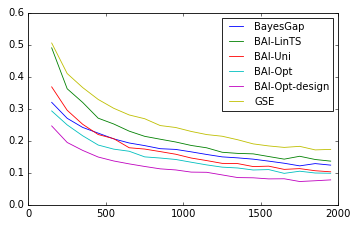

In [39]:
np.random.seed(0)
random.seed(0)

sigma = 1 # observation noise
num_runs = 10000 # number of experiments

K = 100

sub = np.random.randint(movies.shape[0], size=K)
action_matrix = movies[sub, :]
action_matrix = action_matrix[~np.all(action_matrix == 0, axis=1)]
K, _ = np.shape(action_matrix)
print(f'K = {K}')

algs = [
  #("LinearExploration", "pink", '-',"LinearExploration"),
  #("OD_LinBAI", "yellow", '-',"OD-LinBAI"),
  ("BayesGap", "green", '-',"BayesGap"),
  ("BAILinTS", "cyan", "-", "BAI-LinTS"),
  ("BAIUniform", "green", "-", "BAI-Uni"),
  ("BAIOpt", "black", "-", "BAI-Opt"),
  ("BAIOptimalDesign", "red", "-", "BAI-Opt-design"),
  ("GSE", "red", "-", "GSE"),
]

exps = [
  {"K":K}
]

budgets_ = np.arange(150, 2000, 100)

for exp in exps:
  
  # set parameters of the experiment
  for attr, val in exp.items():
    globals()[attr] = val
  results_ = defaultdict(list)

  mu_0 = mu_user 
  Sigma_0 = np.diag(var_user)
  Sigma_0_inv = np.linalg.inv(Sigma_0)

  for n in budgets_:
      
      # Allocation by optimization
      w_optim = compute_w_opt(sigma, mu_0, Sigma_0, action_matrix, n, alpha=0.3, num_MC=100) 
      w_optim /= w_optim.sum()
      #print(np.round(w_optim, 1))

      # Allocation by optimal design
      w_optimal_design = BG_opt(n, K, action_matrix, Sigma_0_inv, sigma).astype(float)
      w_optimal_design /= w_optimal_design.sum()

      n_ts = K  # warm-up rounds for TS

      print('Running experiments with n =', n)
      #print('warm up phase = ', n_ts)
      print('\n')
            
      # bandit environments
      envs = []
      for run in range(num_runs):
        # generate arm means 
        theta = users[np.random.randint(users.shape[0], size=1), :].reshape(-1)

        # initialize bandit environment
        env = LinearBanditEnvironment(action_matrix, theta, sigma)

        # pass parameters for algorithm initialization (not used in simulation)
        env.mu_0 = np.copy(mu_0)
        env.Sigma_0 = np.copy(Sigma_0)
        env.Sigma_0_inv = np.copy(Sigma_0_inv)
        env.n_ts = n_ts
        env.w_optimal_design = w_optimal_design
        env.w_optim = w_optim
        envs.append(env)

      # simulation
      for alg in algs:
        print(alg)
        # all runs for a single algorithm
        alg_class = globals()[alg[0]]
        error_prob, error_indicators = evaluate(alg_class, envs, n)
        #evaluate_one(alg_class, envs[0], n)
        results_[alg[3]].append(error_indicators)

np.save('results/movielens_K={}_d={}.npy'.format(K, d), results_)
for alg in algs:
    plt.plot(budgets_, np.mean(results_[alg[3]], axis=1), label=alg[3])
plt.legend()